In [1]:
import os
import sys
import logging

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize


path_lib_dir = '/workspace/lib'
# check if path has been added
if os.path.dirname(os.path.abspath(path_lib_dir)) not in sys.path:
    sys.path.append(path_lib_dir)

from lib.dataset import Dataset
from lib.augment import Processing

logging.basicConfig(level=logging.INFO)

2023-12-12 17:36:42.424632: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 17:36:42.424670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 17:36:42.424690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 17:36:42.431390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.14.0'

In [3]:
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU not available")

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

GPU is available
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


2023-12-12 17:36:45.567768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22981 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-12-12 17:36:45.568954: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /device:GPU:0 with 22981 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5


In [4]:
seed = 1234
# Set the seed for reproducibility

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

dataset = Dataset(seed=seed, dataset_name='rock_paper_scissors')
dataset.load(validation_proportion=0.15)

ds_train = dataset.ds_train
ds_val = dataset.ds_val

# retrieve length of dataset from ds_train
len_ds_train = len(ds_train)
len_ds_val = len(ds_val)
len_ds_test = len(dataset.ds_test)

INFO:absl:Load dataset info from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Reusing dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)
2023-12-12 17:36:45.610546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22981 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:65:00.0, compute capability: 7.5
INFO:absl:Constructing tf.data.Dataset rock_paper_scissors for split ['train'], from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/rock_paper_scissors/3.0.0
INFO:absl:Reusing dataset rock_paper_scissors (/root/tensorflow_datasets/rock_paper_scissors/3.0.0)


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


INFO:absl:Constructing tf.data.Dataset rock_paper_scissors for split ['train[:2142]', 'train[-378:]', 'test'], from /root/tensorflow_datasets/rock_paper_scissors/3.0.0


In [5]:
len_ds_train, len_ds_val, len_ds_test

(2142, 378, 372)

In [6]:
# get cpu threads 
cpu_count = os.cpu_count()
workers = max(1, cpu_count - 2)
print('cpu_count', cpu_count)
print('workers', workers)

cpu_count 12
workers 10


In [7]:
def prepare_dataset(ds, seed, target_size=(224, 224), batch_size=64, augment=True, shuffle=True):
    preprocessing = Processing(
            random_flip_left_right=True,
            random_brightness=0.1,
            random_contrast=0.1,
            random_rotation=30,
            random_saturation=0.1,
            random_hue=0.05,
            random_crop=0.1,
    )

    ds_prepared = ds.cache()
    if shuffle:
        ds_prepared = ds_train.shuffle(len(ds_train), seed=seed)
    ds_prepared = preprocessing.preprocess(ds_prepared, target_size, augment)
    ds_prepared = ds_prepared.batch(batch_size)
    ds_prepared = ds_prepared.prefetch(tf.data.AUTOTUNE)
    return ds_prepared

In [8]:
overview_models = { }

Following best practice from
https://www.tensorflow.org/guide/keras/transfer_learning

In [9]:
def create_model(model_class, seed, target_size=(160, 160), dropout_rate=0.2, optimizer=tf.keras.optimizers.legacy.Adam()):
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    input_shape=target_size + (3,)

    base_model = model_class(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    # freeze base model
    base_model.trainable = False
    # set base model to inference mode (not training)
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # add head comparable to original MobileNetV2
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    if dropout_rate is not None:
        # Add a fully-connected layer
        x = tf.keras.layers.Dense(1024, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [10]:
def train_model(
        model, 
        model_name, 
        overview_models, 
        ds_train, 
        ds_val,
        seed, 
        target_size, 
        workers,
        batch_size=64,
        epochs=20,):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)
    ds_train_prepared = prepare_dataset(ds_train, seed, target_size=target_size, batch_size=batch_size, augment=True, shuffle=True)
    ds_val_prepared = prepare_dataset(ds_val, seed, target_size=target_size, batch_size=batch_size, augment=False, shuffle=False)

    # model.compile(
    #     optimizer=optimizer,
    #     loss='sparse_categorical_crossentropy',
    #     metrics=['accuracy']
    # )

    #ds_train_prepared = ds_train_prepared.repeat()
    history = model.fit(
        ds_train_prepared,
        epochs=epochs,
        # batch_size=batch_size,
        validation_data=ds_val_prepared,
        workers=workers,
    )

    y_true = np.concatenate([y for x, y in ds_val_prepared], axis=0)
    y_pred = np.argmax(model.predict(ds_val_prepared), axis=1)
    cm = confusion_matrix(y_true, y_pred)

    overview_models[model_name] = {}
    overview_models[model_name]['model'] = model
    overview_models[model_name]['num_params'] = model.count_params()
    overview_models[model_name]['history'] = history.history
    overview_models[model_name]['cm'] = cm

    return overview_models


Checking for model architecture to go with.

In [11]:
def plot_history(overview_models, plot_model_size=True, ymin=None, ymax=None):
    nplot = 3 if plot_model_size else 2
    plt.figure(figsize=(nplot*6, 5))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    alpha = 0.6
    # Plot training & validation accuracy values
    plt.subplot(1, nplot, 1)
    for i, (model_name, overview) in enumerate(overview_models.items()):
        history = overview['history']
        color = colors[i % len(colors)]
        plt.plot(history['accuracy'], label=f'{model_name} Train', linestyle='solid', color=color, alpha=alpha)
        plt.plot(history['val_accuracy'], label=f'{model_name} Validation', linestyle='dashed', color=color, alpha=alpha)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    if ymin is not None:
        plt.ylim(ymin, 1 if ymax is None else ymax)
        
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, nplot, 2)
    for i, (model_name, overview) in enumerate(overview_models.items()):
        history = overview['history']
        color = colors[i % len(colors)]
        plt.plot(history['loss'], label=f'{model_name} Train', linestyle='solid', color=color)
        plt.plot(history['val_loss'], label=f'{model_name} Validation', linestyle='dashed', color=color)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    if plot_model_size:
        # Plot model size vs validation accuracy in the last epoch
        plt.subplot(1, 3, 3)
        min_val = np.inf
        max_val = 0
        for i, (model_name, overview) in enumerate(overview_models.items()):
            history = overview['history']
            model_size = overview['num_params']
            val_accuracy_last_epoch = history['val_accuracy'][-1]
            plt.scatter(model_size, val_accuracy_last_epoch, color=colors[i % len(colors)], label=model_name, alpha=alpha)
            min_val = min(min_val, model_size)
            max_val = max(max_val, model_size)
        plt.title('Model size vs Validation accuracy')
        plt.xlim(min_val*0.9, max_val*1.1)
        plt.ylabel('Validation accuracy in the last epoch')
        plt.xlabel('Model size')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [12]:
def plot_cm(overview_models):
    num_models = len(overview_models)
    fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(3*num_models, 3))

    for ax, (model_name, model_info) in zip(axes, overview_models.items()):
        # Get the confusion matrix
        cm = model_info['cm']
        cm_normalized = normalize(cm, axis=1, norm='l1')

        cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'{model_name}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

        for i in range(cm_normalized.shape[0]):
            for j in range(cm_normalized.shape[1]):
                ax.text(j, i, f"{cm_normalized[i, j]:.2f}\n({cm[i, j]})", ha="center", va="center", color="red")

    plt.suptitle('Confusion Matrices, normalized value, absolute values in brackets')
    plt.tight_layout()
    plt.show()

In [13]:
func_mobilenetv2 = tf.keras.applications.MobileNetV2
func_densenet121 = tf.keras.applications.DenseNet121

target_size_mobilenetv2 = (160, 160)
target_size_densenet121 = (200, 200)

In [14]:
epochs = 20
batch_size = 64
dropout_rate = None

logging.info(f'training model MobileNetV2')
model_mobilenetv2 = create_model(func_mobilenetv2, seed=seed, target_size=target_size_mobilenetv2, dropout_rate=dropout_rate)
overview = train_model(
    model_mobilenetv2, 
    'MobileNetV2', 
    overview_models, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size_mobilenetv2, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

logging.info(f'training model DenseNet121')
model_densenet121 = create_model(func_densenet121, seed=seed, target_size=target_size_densenet121, dropout_rate=dropout_rate)
overview = train_model(
    model_densenet121, 
    'DenseNet121', 
    overview_models, 
    ds_train, 
    dataset.ds_val, 
    seed, 
    target_size=target_size_densenet121, 
    workers=workers,
    batch_size=batch_size,  
    epochs=epochs,
)

INFO:root:training model MobileNetV2


Epoch 1/20


2023-12-12 17:36:59.066047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


34/34 [==============================] - 9s 133ms/step - loss: 0.4956 - accuracy: 0.8226 - val_loss: 0.1754 - val_accuracy: 0.9603
Epoch 2/20
34/34 [==============================] - 3s 75ms/step - loss: 0.1376 - accuracy: 0.9655 - val_loss: 0.1009 - val_accuracy: 0.9709
Epoch 3/20
34/34 [==============================] - 3s 78ms/step - loss: 0.0872 - accuracy: 0.9855 - val_loss: 0.0731 - val_accuracy: 0.9815
Epoch 4/20
34/34 [==============================] - 3s 76ms/step - loss: 0.0638 - accuracy: 0.9907 - val_loss: 0.0582 - val_accuracy: 0.9868
Epoch 5/20
34/34 [==============================] - 3s 77ms/step - loss: 0.0529 - accuracy: 0.9897 - val_loss: 0.0493 - val_accuracy: 0.9894
Epoch 6/20
34/34 [==============================] - 3s 80ms/step - loss: 0.0410 - accuracy: 0.9944 - val_loss: 0.0415 - val_accuracy: 0.9894
Epoch 7/20
34/34 [==============================] - 3s 77ms/step - loss: 0.0355 - accuracy: 0.9953 - val_loss: 0.0367 - val_accuracy: 0.9894
Epoch 8/20
34/34 [=====

INFO:root:training model DenseNet121


Epoch 1/20
34/34 [==============================] - 19s 276ms/step - loss: 0.5714 - accuracy: 0.7736 - val_loss: 0.2808 - val_accuracy: 0.8862
Epoch 2/20
34/34 [==============================] - 5s 124ms/step - loss: 0.1571 - accuracy: 0.9683 - val_loss: 0.1407 - val_accuracy: 0.9577
Epoch 3/20
34/34 [==============================] - 5s 123ms/step - loss: 0.1015 - accuracy: 0.9879 - val_loss: 0.1053 - val_accuracy: 0.9709
Epoch 4/20
34/34 [==============================] - 5s 126ms/step - loss: 0.0851 - accuracy: 0.9888 - val_loss: 0.0835 - val_accuracy: 0.9788
Epoch 5/20
34/34 [==============================] - 5s 124ms/step - loss: 0.0715 - accuracy: 0.9935 - val_loss: 0.0750 - val_accuracy: 0.9762
Epoch 6/20
34/34 [==============================] - 5s 124ms/step - loss: 0.0610 - accuracy: 0.9967 - val_loss: 0.0659 - val_accuracy: 0.9815
Epoch 7/20
34/34 [==============================] - 5s 122ms/step - loss: 0.0583 - accuracy: 0.9949 - val_loss: 0.0576 - val_accuracy: 0.9868
Epoch

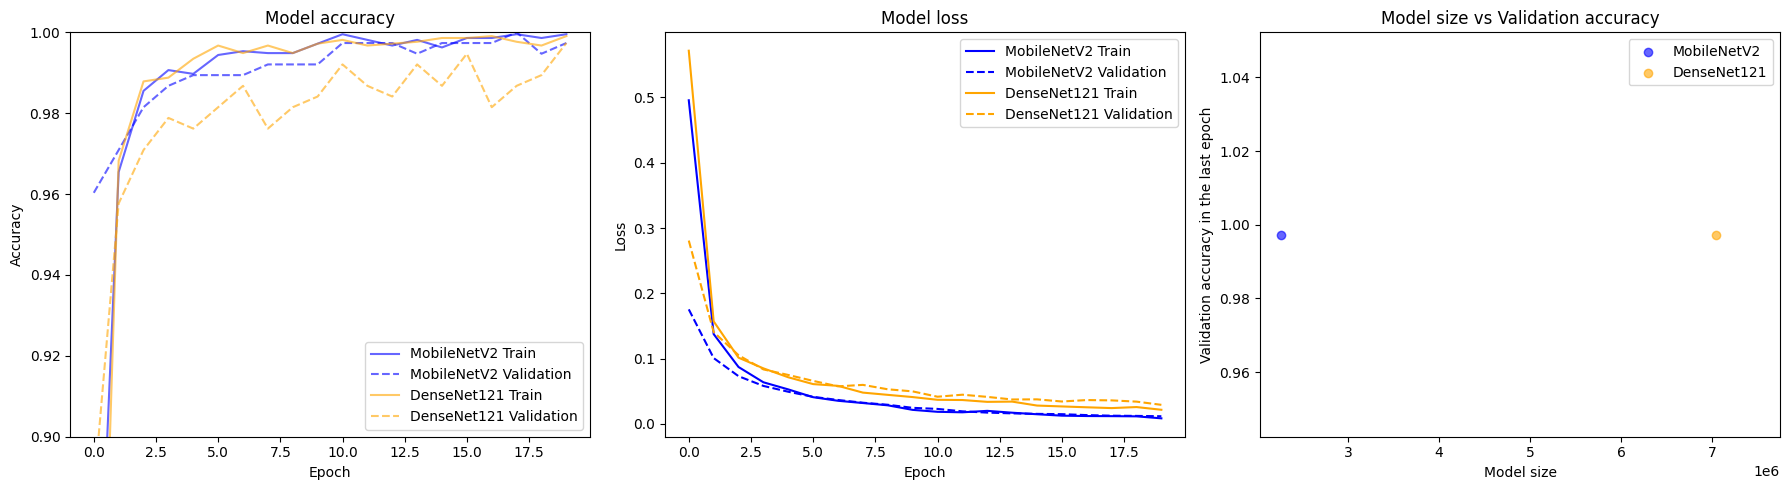

In [17]:
plot_history(overview_models, ymin=0.9)

MobileNetv2 with input size (160,160) has less parameter than DenseNet121 with input size (200,200). Additionally the MobileNetv2 model performs better as the accuracy on the valdiation dataset is higher and the gap between validation and training accuracy is smaller.

Comparing confusion matrices of both models.

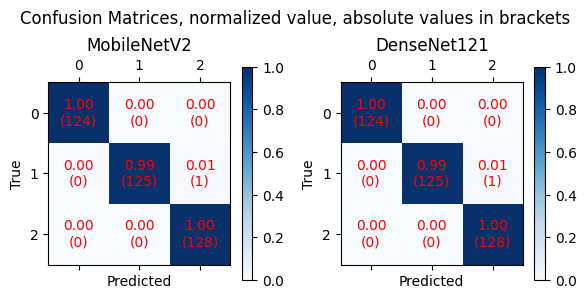

In [18]:
plot_cm(overview_models)

There are less missclassifications in the MobileNetv2 model. Therefore deciding to go with the MobileNetv2 model for further investigating hyperparameters.

Trying out an additional layer with different dropout rates.

In [19]:
overview_mobilenetv2 = {}
overview_mobilenetv2['MobileNetV2'] = overview_models['MobileNetV2']

epochs=20
target_size=(160, 160)
batch_size=64

dropout_rate = 0.2
logging.info(f'training model MobileNetV2 - additional layer with dropout {dropout_rate}')
model_mobilenetv2_dropout_0_2 = create_model(func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate)
overview_mobilenetv2 = train_model(
    model_mobilenetv2_dropout_0_2, 
    'MobileNetV2 dropout 0.2', 
    overview_mobilenetv2, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)


dropout_rate = 0.4
logging.info(f'training model MobileNetV2 - additional layer with dropout {dropout_rate}')
model_mobilenetv2_dropout_0_4 = create_model(func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate)
overview_mobilenetv2 = train_model(
    model_mobilenetv2_dropout_0_4, 
    'MobileNetV2 dropout 0.4', 
    overview_mobilenetv2, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

INFO:root:training model MobileNetV2 - additional layer with dropout 0.2


Epoch 1/20
34/34 [==============================] - 9s 106ms/step - loss: 1.6278 - accuracy: 0.7965 - val_loss: 0.0708 - val_accuracy: 0.9762
Epoch 2/20
34/34 [==============================] - 3s 78ms/step - loss: 0.0495 - accuracy: 0.9823 - val_loss: 0.0575 - val_accuracy: 0.9762
Epoch 3/20
34/34 [==============================] - 3s 78ms/step - loss: 0.0271 - accuracy: 0.9930 - val_loss: 0.0386 - val_accuracy: 0.9868
Epoch 4/20
34/34 [==============================] - 3s 78ms/step - loss: 0.0146 - accuracy: 0.9972 - val_loss: 0.0275 - val_accuracy: 0.9894
Epoch 5/20
34/34 [==============================] - 3s 80ms/step - loss: 0.0180 - accuracy: 0.9944 - val_loss: 0.0151 - val_accuracy: 0.9974
Epoch 6/20
34/34 [==============================] - 3s 77ms/step - loss: 0.0215 - accuracy: 0.9935 - val_loss: 0.0170 - val_accuracy: 0.9921
Epoch 7/20
34/34 [==============================] - 3s 82ms/step - loss: 0.0151 - accuracy: 0.9958 - val_loss: 0.0144 - val_accuracy: 0.9974
Epoch 8/20
3

INFO:root:training model MobileNetV2 - additional layer with dropout 0.4


Epoch 1/20
34/34 [==============================] - 8s 111ms/step - loss: 1.6556 - accuracy: 0.8021 - val_loss: 0.1148 - val_accuracy: 0.9709
Epoch 2/20
34/34 [==============================] - 3s 82ms/step - loss: 0.0625 - accuracy: 0.9776 - val_loss: 0.0392 - val_accuracy: 0.9894
Epoch 3/20
34/34 [==============================] - 3s 77ms/step - loss: 0.0347 - accuracy: 0.9888 - val_loss: 0.0248 - val_accuracy: 0.9894
Epoch 4/20
34/34 [==============================] - 3s 80ms/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 0.0196 - val_accuracy: 0.9921
Epoch 5/20
34/34 [==============================] - 3s 79ms/step - loss: 0.0225 - accuracy: 0.9921 - val_loss: 0.0158 - val_accuracy: 0.9947
Epoch 6/20
34/34 [==============================] - 3s 79ms/step - loss: 0.0154 - accuracy: 0.9944 - val_loss: 0.0077 - val_accuracy: 0.9974
Epoch 7/20
34/34 [==============================] - 3s 79ms/step - loss: 0.0116 - accuracy: 0.9944 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 8/20
3

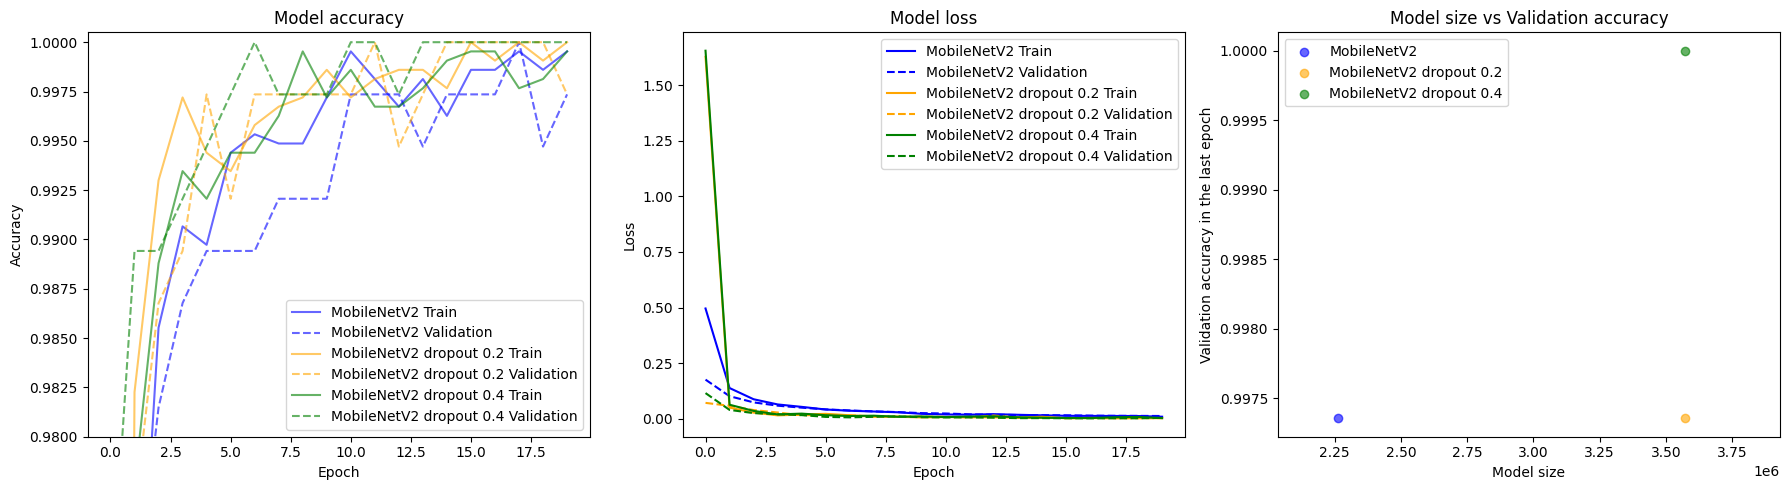

In [21]:
plot_history(overview_mobilenetv2, plot_model_size=True, ymin=0.98, ymax=1.0005)

Model performance is better with additional layer and dropout of `0.2`.

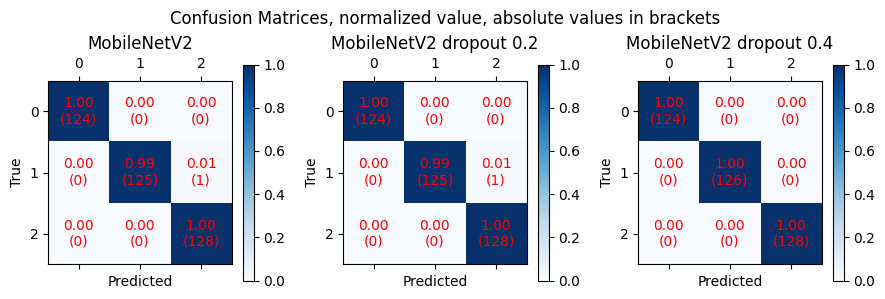

In [22]:
plot_cm(overview_mobilenetv2)

Confusion matrix results for all three models is the same.

Therefore deciding to go with the MobileNetv2 model without additional layer and dropout for further hyperparameter tuning.

Next comparing performance to using learning rate decay.

In [ ]:
overview_mobilenetv2_lr_schedule = {}
overview_mobilenetv2_lr_schedule['MobileNetV2'] = overview_mobilenetv2['MobileNetV2']

epochs=20
target_size=(160, 160)
batch_size=64

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
dropout_rate=0.2
model_mobilenetv2_lr_schedule = create_model(
    func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate, optimizer=optimizer)
overview_mobilenetv2_lr_schedule = train_model(
    model_mobilenetv2_lr_schedule, 
    'MobileNetV2 lr schedule', 
    overview_mobilenetv2_lr_schedule, 
    ds_train, 
    ds_val, 
    seed, 
    target_size=target_size, 
    workers=workers,
    batch_size=batch_size,
    epochs=epochs,
)

In [ ]:
plot_history(overview_mobilenetv2_lr_schedule, plot_model_size=False, ymin=0.95, ymax=1.001)

In [ ]:
plot_cm(overview_mobilenetv2_lr_schedule)

## Conclusion/Summary

The following has been tried out

1. Training models based on different model architectures. MobileNetv2 has less parameters and performed better.
    - MobileNetv2 with input size (160,160)
    - DenseNet121 with input size (200,200)

1. Training MobileNetv2 models with and additional dense layer and different dropout rates. The model with the additional layer and dropout `0.2` performed best.
   
1. Training MobileNetv2 models (additional dense layer and dropout `0.2`) with and without learning rate decay. The model with learning rate decay performed best.

Final Model 

- MobileNetv2 with input size (160,160)
- with additional dense layer and dropout `0.2`
- with learning rate decay
- Stopping training after 9 epochs

Check performance on test dataset.

In [ ]:
epochs=20
target_size = (160, 160)
batch_size = 64
dropout_rate = 0.2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
ds_full_train_prepared = prepare_dataset(dataset.ds_train_full, seed, target_size=target_size, batch_size=batch_size, augment=True, shuffle=True)
final_model = create_model(func_mobilenetv2, seed=seed, target_size=target_size, dropout_rate=dropout_rate)
history = final_model.fit(
    ds_full_train_prepared,
    epochs=epochs,
    workers=workers,
)



ds_test_prepared = prepare_dataset(dataset.ds_test, seed, target_size=target_size, batch_size=batch_size, augment=False, shuffle=False)
y_true = np.concatenate([y for x, y in ds_test_prepared], axis=0)
y_pred = np.argmax(final_model.predict(ds_test_prepared), axis=1)
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(3, 3))
cm_normalized = normalize(cm, axis=1, norm='l1')

cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
fig.colorbar(cax, ax=ax)
ax.set_title('MobileNetV2 lr schedule - performance on test dataset')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j, i, f"{cm_normalized[i, j]:.2f}\n({cm[i, j]})", ha="center", va="center", color="red")

# print labels
labels = dataset.ds_info.features['label'].names
num_labels = len(labels)
ax.set_xticks(np.arange(num_labels))
ax.set_yticks(np.arange(num_labels))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)


loss, accuracy = final_model.evaluate(ds_test_prepared)
print("Evaluation on test data")
print(f"Loss: {loss:.3f}")
print(f"Accuracy: {accuracy:.3f}")

In [ ]:
# final_model.save('final_model.tf')

Exporting training logic to separate script [`train.py`](train.py).